# This is the data cleaning Notebok for the project

In [764]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

In [765]:
df = pd.read_excel("marketing_data.xlsx")

## Data Profiling

In [766]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
dtype: object

## Data Preprocessing

In [767]:
# Converting year of birth into age
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']
print(df[['Age', 'Year_Birth']])
print(df['Age'].unique())

      Age  Year_Birth
0      54        1970
1      63        1961
2      66        1958
3      57        1967
4      35        1989
...   ...         ...
2235   48        1976
2236   47        1977
2237   48        1976
2238   46        1978
2239   55        1969

[2240 rows x 2 columns]
[ 54  63  66  57  35  70  77  45  65  43  55  47  64  58  48  59  68  49
  53  38  52  50  34  37  40  56  69  41  51  46  72  62  60  42  61  67
  44  79  75  76  71  78  39  32  80  73  36  74  30  31  33 131  28  29
 125  81  83  84 124]


In [768]:
df['Marital_Status'] = df['Marital_Status'].astype(str)
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
Age                      int64
dtype: object

In [769]:
# Fixing the format for Dt_customer
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed')
print(df.shape)
df = df[(df['Dt_Customer'].dt.year - df['Year_Birth']) > 18]
print(df.shape)
df['Dt_Customer'] = df['Dt_Customer'].astype(str)
print(df)

(2240, 23)
(2234, 23)
         ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      1826        1970  Graduation       Divorced  84835.0        0   
1         1        1961  Graduation         Single  57091.0        0   
2     10476        1958  Graduation        Married  67267.0        0   
3      1386        1967  Graduation       Together  32474.0        1   
4      5371        1989  Graduation         Single  21474.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10142        1976         PhD       Divorced  66476.0        0   
2236   5263        1977    2n Cycle        Married  31056.0        1   
2237     22        1976  Graduation       Divorced  46310.0        1   
2238    528        1978  Graduation        Married  65819.0        0   
2239   4070        1969         PhD        Married  94871.0        0   

      Teenhome Dt_Customer  Recency  MntWines  ...  MntSweetProducts  \
0            0  2014-06-16        0      

## Filling all null income values

In [770]:
df['Income'].head()

0    84835.0
1    57091.0
2    67267.0
3    32474.0
4    21474.0
Name: Income, dtype: float64

In [771]:
unique_values = df['Education'].unique()
print(unique_values)

['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']


In [772]:
df['Marital_Status'].unique()

array(['Divorced', 'Single', 'Married', 'Together', 'Widow', 'YOLO',
       'Alone', 'Absurd'], dtype=object)

In [773]:
df['Marital_Status'] = df['Marital_Status'].replace(['YOLO', 'Alone', 'Divorced', 'Widow'], 'Single')
df['Marital_Status'] = df['Marital_Status'].replace(['Absurd'], 'Married')

In [774]:
df['Marital_Status'].unique()

array(['Single', 'Married', 'Together'], dtype=object)

In [775]:
def countMembers(row):
    if row['Marital_Status'] == 'Single':
        return row['Kidhome'] + row['Teenhome'] + 1
    else:
        return row['Kidhome'] + row['Teenhome'] + 2

df['HouseHoldMembers'] = df.apply(countMembers, axis=1)

In [776]:
df['Education'] = df['Education'].replace(['2n Cycle'], 'n_Cycle')

In [777]:
Graduation_mean = df[df['Education'] == 'Graduation']
Graduation_mean = Graduation_mean['Income'].mean()
print(Graduation_mean)

52656.84290843806


In [778]:
PhD_mean = df[df['Education'] == 'PhD']
PhD_mean = PhD_mean['Income'].mean()
print(PhD_mean)

56145.31392931393


In [779]:
TwoN_Cycle_mean = df[df['Education'] == 'n_Cycle']
TwoN_Cycle_mean = TwoN_Cycle_mean['Income'].mean()
print(TwoN_Cycle_mean)

47488.649746192896


In [780]:
Master_mean = df[df['Education'] == 'Master']
Master_mean = Master_mean['Income'].mean()
print(Master_mean)

52917.53424657534


In [781]:
Basic_mean = df[df['Education'] == 'Basic']
Basic_mean = Basic_mean['Income'].mean()
print(Basic_mean)

20417.30188679245


In [782]:
df['Total_Children'] = df.loc[:, 'Kidhome'] + df.loc[:, 'Teenhome']
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,HouseHoldMembers,Total_Children
0,1826,1970,Graduation,Single,84835.0,0,0,2014-06-16,0,189,...,1,4,4,6,1,1,0,54,1,0
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,1,7,3,7,5,1,0,63,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,1,3,2,5,2,0,0,66,3,1
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,...,1,1,0,2,7,0,0,57,4,2
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,...,2,3,1,2,7,1,0,35,2,1


In [783]:
null_income = df[df['Income'].isnull()]
null_income['Income'][null_income['Education'] == 'Graduation'] = Graduation_mean
null_income['Income'][null_income['Education'] == 'PhD'] = PhD_mean
null_income['Income'][null_income['Education'] == 'n_Cycle'] = TwoN_Cycle_mean
null_income['Income'][null_income['Education'] == 'Master'] = Master_mean
null_income['Income'][null_income['Education'] == 'Basic'] = Basic_mean
print(null_income)

         ID  Year_Birth   Education Marital_Status        Income  Kidhome  \
134    8996        1957         PhD        Married  56145.313929        2   
262    1994        1983  Graduation        Married  52656.842908        1   
394    3769        1972         PhD       Together  56145.313929        1   
449    5255        1986  Graduation         Single  52656.842908        1   
525    8268        1961         PhD        Married  56145.313929        0   
590   10629        1973     n_Cycle        Married  47488.649746        1   
899   10475        1970      Master       Together  52917.534247        0   
997    9235        1957  Graduation         Single  52656.842908        1   
1096   4345        1964     n_Cycle         Single  47488.649746        1   
1185   7187        1969      Master       Together  52917.534247        1   
1213   8720        1978     n_Cycle       Together  47488.649746        0   
1312   8557        1982  Graduation         Single  52656.842908        1   

C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_16904\667327407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_income['Income'][null_income['Education'] == 'Graduation'] = Graduation_mean
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_16904\667327407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_income['Income'][null_income['Education'] == 'PhD'] = PhD_mean
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_16904\667327407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [784]:
df['Income'][df['Income'].isnull()] = null_income['Income']
df.head(50)

C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_16904\140808848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Income'][df['Income'].isnull()] = null_income['Income']


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,HouseHoldMembers,Total_Children
0,1826,1970,Graduation,Single,84835.0,0,0,2014-06-16,0,189,...,1,4,4,6,1,1,0,54,1,0
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,1,7,3,7,5,1,0,63,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,1,3,2,5,2,0,0,66,3,1
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,...,1,1,0,2,7,0,0,57,4,2
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,...,2,3,1,2,7,1,0,35,2,1
5,7348,1958,PhD,Single,71691.0,0,0,2014-03-17,0,336,...,1,4,7,5,2,1,0,66,1,0
6,4073,1954,n_Cycle,Married,63564.0,0,0,2014-01-29,0,769,...,1,10,10,7,6,1,0,70,2,0
7,1991,1967,Graduation,Together,44931.0,0,1,2014-01-18,0,78,...,1,2,1,3,5,0,0,57,3,1
8,4047,1954,PhD,Married,65324.0,0,1,2014-11-01,0,384,...,3,6,2,9,4,0,0,70,3,1
9,9477,1954,PhD,Married,65324.0,0,1,2014-11-01,0,384,...,3,6,2,9,4,0,0,70,3,1


In [785]:

# Adding a column for the buying power of each customer
df['Total_Spent'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
df['BuyingPower'] = df['Income'] - (df['Total_Spent'] / 2)

In [786]:
from scipy import stats


z_age = np.abs(stats.zscore(df['Age']))
z_income = np.abs(stats.zscore(df['Income']))
z_buying_power = np.abs(stats.zscore(df['BuyingPower']))
threshold_z = 3


print("Original DataFrame Shape:", df.shape)
age_outlier_indices = np.where(z_age > threshold_z)[0]
income_outlier_indices = np.where(z_income > threshold_z)[0]
buying_indices = np.where(z_buying_power > threshold_z)[0]

outlier_indices = np.array(list(set(age_outlier_indices) | set(income_outlier_indices) | set(buying_indices)))

df = df.drop(outlier_indices)
print("DataFrame Shape after Removing Outliers:", df.shape)

Original DataFrame Shape: (2234, 27)
DataFrame Shape after Removing Outliers: (2223, 27)


In [787]:
df['BuyingPower'].head()

0    84240.0
1    56802.5
2    67141.5
3    32468.5
4    21428.5
Name: BuyingPower, dtype: float64

In [788]:
df.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Response               0
Complain               0
Age                    0
HouseHoldMembers       0
Total_Children         0
Total_Spent            0
BuyingPower            0
dtype: int64

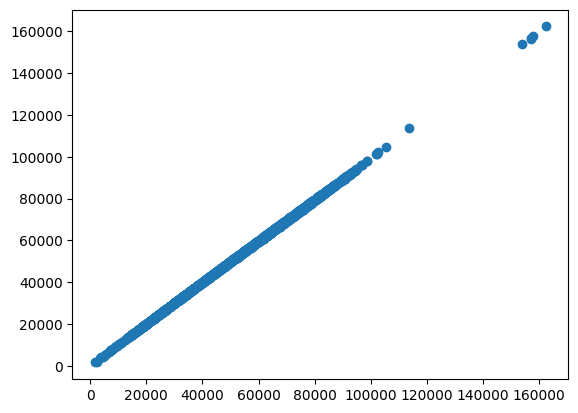

In [789]:
plt.scatter(df['Income'], df['BuyingPower'])

In [790]:
df['TotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [791]:
def calculate_days_diff(row):
  return (today - row['Dt_CustomerConverted']).days

df['Dt_CustomerConverted'] = pd.to_datetime(df['Dt_Customer'])
today = datetime.today()
df['SinceEnrolled'] = df.apply(calculate_days_diff, axis=1)

In [792]:
df['Interest'] = df['NumWebVisitsMonth'] + df['Recency'] 

In [793]:

# df = df[df['BuyingPower']< 0.05]
# df = df[df['Income'] < 200000]
df.shape

(2223, 31)

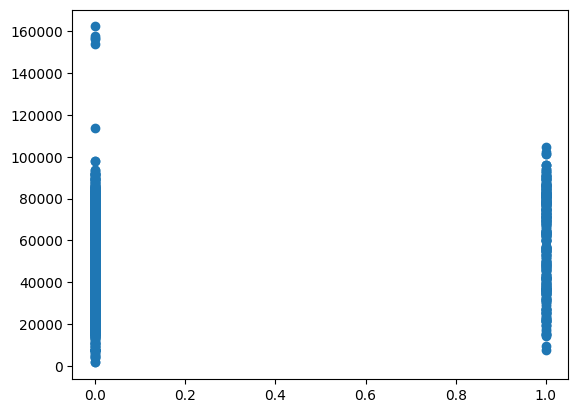

In [794]:
plt.scatter(df['Response'], df['BuyingPower'])    

In [795]:
print(df[df['Marital_Status'] == 'Married'].count())

ID                      861
Year_Birth              861
Education               861
Marital_Status          861
Income                  861
Kidhome                 861
Teenhome                861
Dt_Customer             861
Recency                 861
MntWines                861
MntFruits               861
MntMeatProducts         861
MntFishProducts         861
MntSweetProducts        861
MntGoldProds            861
NumDealsPurchases       861
NumWebPurchases         861
NumCatalogPurchases     861
NumStorePurchases       861
NumWebVisitsMonth       861
Response                861
Complain                861
Age                     861
HouseHoldMembers        861
Total_Children          861
Total_Spent             861
BuyingPower             861
TotalPurchases          861
Dt_CustomerConverted    861
SinceEnrolled           861
Interest                861
dtype: int64


### Customer Lifetime value 

In [796]:
df['CLV'] = (df['Total_Spent'] / 2) * (df['SinceEnrolled'] / 365)

# Average Order Value 

In [797]:
df['AOV'] = df['Total_Spent'] / df['TotalPurchases']

In [798]:
df = df[df['AOV'] < 1.7976931348623157e+308]

# Applied Promo 

In [799]:
df['AppliedPromo'] = (((df['Total_Spent'] - df['MntGoldProds'])/2) - (((df['Total_Spent']-df['MntGoldProds'])/2) * 0.20)) + 499

# Saving to Excel 


In [800]:
df.to_excel('Cleaned_Data.xlsx')

In [801]:
df.count()

ID                      2219
Year_Birth              2219
Education               2219
Marital_Status          2219
Income                  2219
Kidhome                 2219
Teenhome                2219
Dt_Customer             2219
Recency                 2219
MntWines                2219
MntFruits               2219
MntMeatProducts         2219
MntFishProducts         2219
MntSweetProducts        2219
MntGoldProds            2219
NumDealsPurchases       2219
NumWebPurchases         2219
NumCatalogPurchases     2219
NumStorePurchases       2219
NumWebVisitsMonth       2219
Response                2219
Complain                2219
Age                     2219
HouseHoldMembers        2219
Total_Children          2219
Total_Spent             2219
BuyingPower             2219
TotalPurchases          2219
Dt_CustomerConverted    2219
SinceEnrolled           2219
Interest                2219
CLV                     2219
AOV                     2219
AppliedPromo            2219
dtype: int64

In [802]:
df = df[df['Income'] < 200000]
df.count()


ID                      2219
Year_Birth              2219
Education               2219
Marital_Status          2219
Income                  2219
Kidhome                 2219
Teenhome                2219
Dt_Customer             2219
Recency                 2219
MntWines                2219
MntFruits               2219
MntMeatProducts         2219
MntFishProducts         2219
MntSweetProducts        2219
MntGoldProds            2219
NumDealsPurchases       2219
NumWebPurchases         2219
NumCatalogPurchases     2219
NumStorePurchases       2219
NumWebVisitsMonth       2219
Response                2219
Complain                2219
Age                     2219
HouseHoldMembers        2219
Total_Children          2219
Total_Spent             2219
BuyingPower             2219
TotalPurchases          2219
Dt_CustomerConverted    2219
SinceEnrolled           2219
Interest                2219
CLV                     2219
AOV                     2219
AppliedPromo            2219
dtype: int64

In [803]:
df.to_excel('Threshold_Data.xlsx')

In [804]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                  0
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
Age                     0
HouseHoldMembers        0
Total_Children          0
Total_Spent             0
BuyingPower             0
TotalPurchases          0
Dt_CustomerConverted    0
SinceEnrolled           0
Interest                0
CLV                     0
AOV                     0
AppliedPromo            0
dtype: int64

In [805]:
df.head(50)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Total_Children,Total_Spent,BuyingPower,TotalPurchases,Dt_CustomerConverted,SinceEnrolled,Interest,CLV,AOV,AppliedPromo
0,1826,1970,Graduation,Single,84835.0,0,0,2014-06-16,0,189,...,0,1190,84240.0,15,2014-06-16,3543,1,5775.575342,79.333333,887.8
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,0,577,56802.5,18,2014-06-15,3544,5,2801.216438,32.055556,715.0
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,1,251,67141.5,11,2014-05-13,3577,2,1229.900000,22.818182,587.4
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,...,2,11,32468.5,4,2014-11-05,3401,7,51.247945,2.750000,503.4
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,...,1,91,21428.5,8,2014-08-04,3494,7,435.553425,11.375000,521.8
5,7348,1958,PhD,Single,71691.0,0,0,2014-03-17,0,336,...,0,1192,71095.0,17,2014-03-17,3634,2,5933.873973,70.117647,958.6
6,4073,1954,n_Cycle,Married,63564.0,0,0,2014-01-29,0,769,...,0,1215,62956.5,28,2014-01-29,3681,6,6126.595890,43.392857,959.0
7,1991,1967,Graduation,Together,44931.0,0,1,2014-01-18,0,78,...,1,96,44883.0,7,2014-01-18,3692,5,485.523288,13.714286,534.6
8,4047,1954,PhD,Married,65324.0,0,1,2014-11-01,0,384,...,1,544,65052.0,20,2014-11-01,3405,4,2537.424658,27.200000,714.6
9,9477,1954,PhD,Married,65324.0,0,1,2014-11-01,0,384,...,1,544,65052.0,20,2014-11-01,3405,4,2537.424658,27.200000,714.6
